In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm.notebook import tqdm
from scipy import ndimage
import skimage
import skimage.filters

from torchvision.transforms import functional as F

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator,\
    find_non_empty_indices, EMPTY_TENSOR_PIXEL
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [2]:

FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False, should_prefix=True):
    if save_path is not None:
        save_path = os.path.abspath(save_path)
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX) and should_prefix:
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [8]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if row == 0:
                if col == k - 1:
                    ax.set_title('Different Relation')
                elif col == k - 2:
                    ax.set_title('Same Relation')
                else:
                    ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    plt.show()

def plot_cropped_centered_triplets(triplets, canvas_size=(3, 200, 200), edge_color=(1, 0, 0)):
    n = triplets.shape[0]
    k = triplets.shape[1]

    if not isinstance(edge_color, torch.Tensor):
        edge_color = torch.tensor(edge_color, dtype=torch.float32).view(3, 1)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            img = triplets[row, col]
            r1, r2, c1, c2 = find_non_empty_indices(img, EMPTY_TENSOR_PIXEL, color_axis=0)
            img = img[:, r1:r2, c1:c2]
            canvas = torch.ones(*canvas_size)
            h = r2 - r1
            w = c2 - c1
            h_start = torch.div(canvas_size[1] - h, 2, rounding_mode='floor')
            w_start = torch.div(canvas_size[2] - w, 2, rounding_mode='floor')
            canvas[:, h_start:h_start + h, w_start:w_start + w] = img
            canvas[:, h_start - 1, w_start:w_start + w] = edge_color
            canvas[:, h_start + h, w_start:w_start + w] = edge_color
            canvas[:, h_start:h_start + h, w_start - 1] = edge_color
            canvas[:, h_start:h_start + h, w_start + w] = edge_color
            ax.imshow(canvas.permute(1, 2, 0).numpy())

            ax.set_title(f'{h} x {w} = {h * w}')

    fig.tight_layout()

    plt.show()

FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('None', 'Horizontal', 'Vertical', 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path, should_prefix=False)

    plt.show()


GENERATOR_NAMES = ('color bar', 'split text', 'random colors')


def create_stimulus_generators_and_names(names=GENERATOR_NAMES, seed=None, **kwargs):
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))

    generators = (
        build_differet_shapes_stimulus_generator(reference_size=(10, 140), rng=rng, 
        # blur_func=lambda x: cv2.blur(x, (7, 7)), 
        # blur_func=lambda x: skimage.filters.gaussian(x, sigma=1, channel_axis=-1),
        **kwargs), 
        
        build_split_text_stimulus_generator(
            # reference_box_size=10,
            # total_reference_size=(10, 140), n_reference_patches=8,
            # reference_patch_kwargs=dict(ylim=(-70, 70)),
            rng=rng, **kwargs),
        build_random_color_stimulus_generator(reference_size=(10, 140), rng=rng, **kwargs)
    )
    
    return zip(generators, names)

In [9]:
BASELINE_TRIPLET_KWARGS = dict(n_target_types=2, extra_diagonal_margin=0)
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (80, 120),
    (True, True): (40, 80),  
}

# Stimulus conditions we have
* Above/below
    * With two reference objects
        * With or without a gap between them
* Between
* *The above two relations, but sideways (left/right and vertical between)* -- currently not plotted because it's just the regular stimuli transposed, but I can add that demo.
* Diagonal
* With both generators above



# Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FC8CA0DF5E0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FC8CA0DF5E0}


## color bar | above_below | one ref

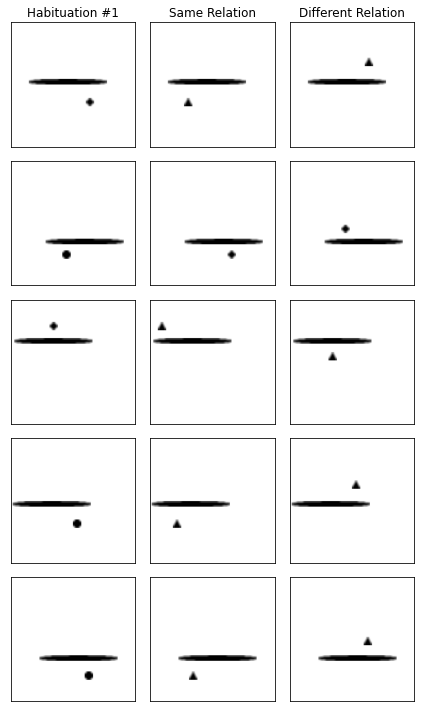

----

## split text | above_below | one ref

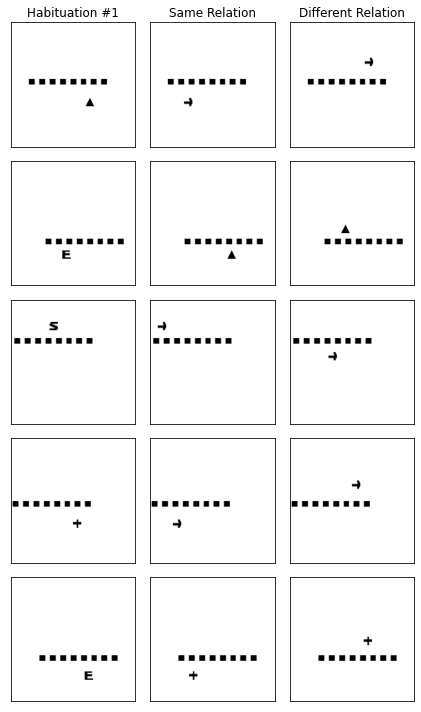

----

## random colors | above_below | one ref

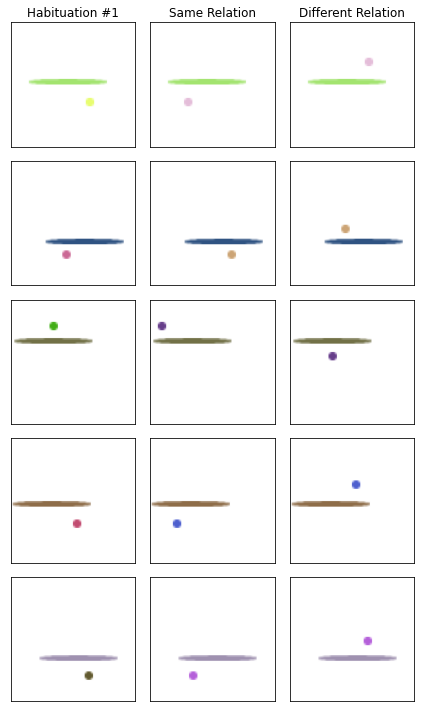

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FC8CA0DFE50}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FC8CA0DFE50}


## color bar | above_below | two refs | non-adjacent refs

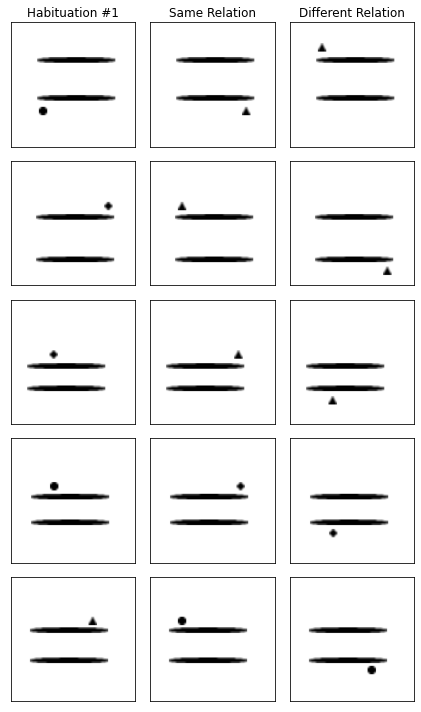

----

## split text | above_below | two refs | non-adjacent refs

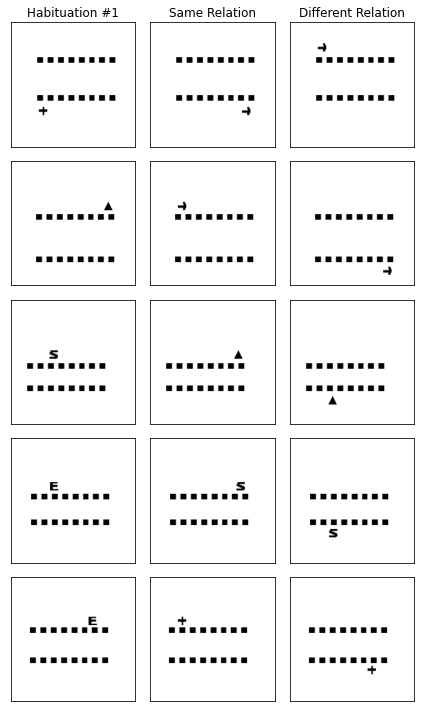

----

## random colors | above_below | two refs | non-adjacent refs

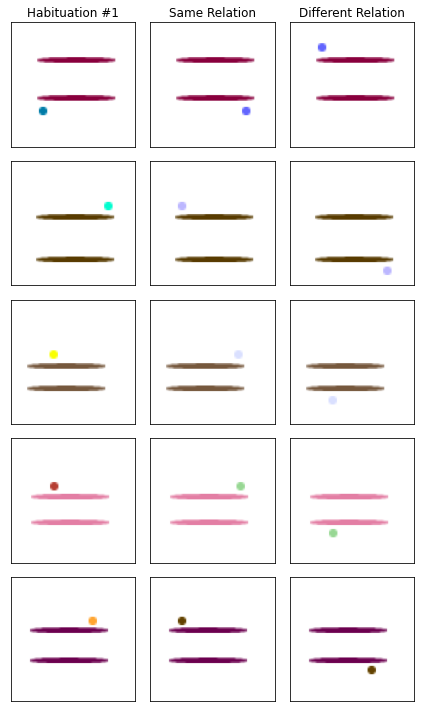

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FC8C2B73400}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FC8C2B73400}


## color bar | above_below | two refs | adjacent refs

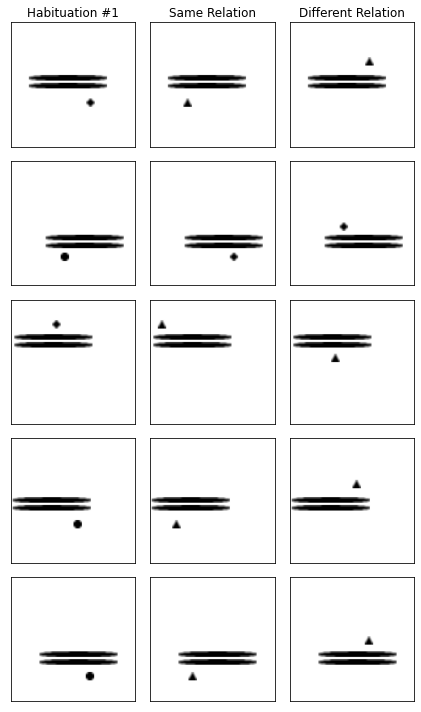

----

## split text | above_below | two refs | adjacent refs

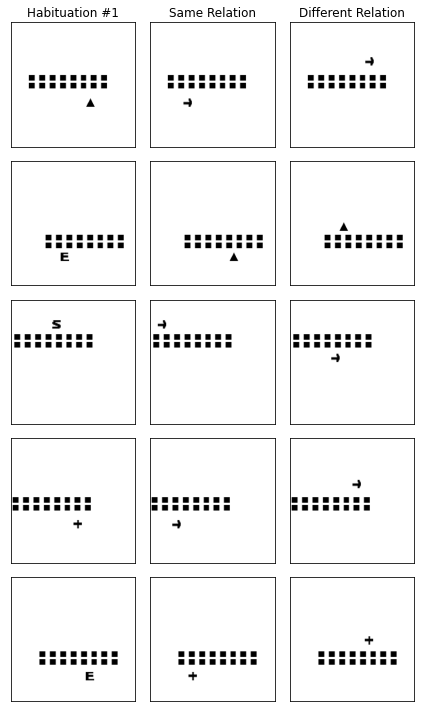

----

## random colors | above_below | two refs | adjacent refs

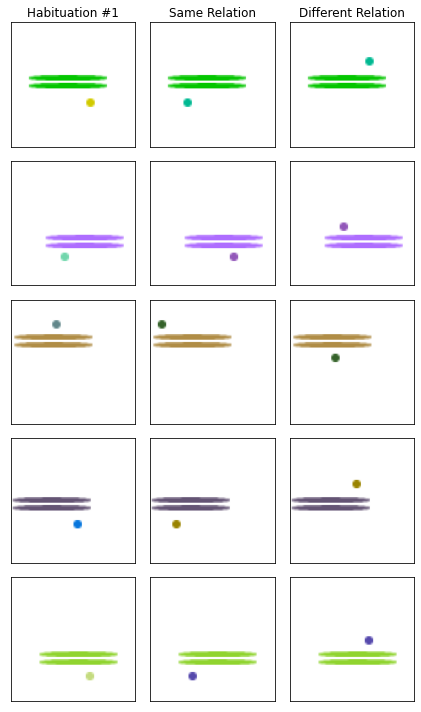

----

In [10]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in create_stimulus_generators_and_names():
            
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

            adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
            title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
            display(Markdown(f'## {title}'))
            triplets = triplet_generator(N_examples, normalize=False)
            plot_triplets(triplets)
            display(Markdown('----'))


# Between/Outside

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD99A0}


## color bar | between

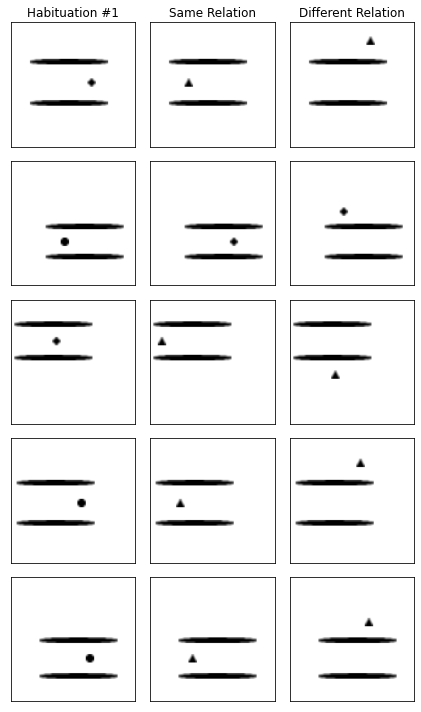

----

In [6]:
relation = BETWEEN_RELATION
distance_endpoints = distance_endpoints_dict[(True, False)]
N_examples = 5

display(Markdown('# Between/Outside'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for stimulus_generator, generator_name in create_stimulus_generators_and_names():
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation}'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))


# Diagonal Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 30 degrees

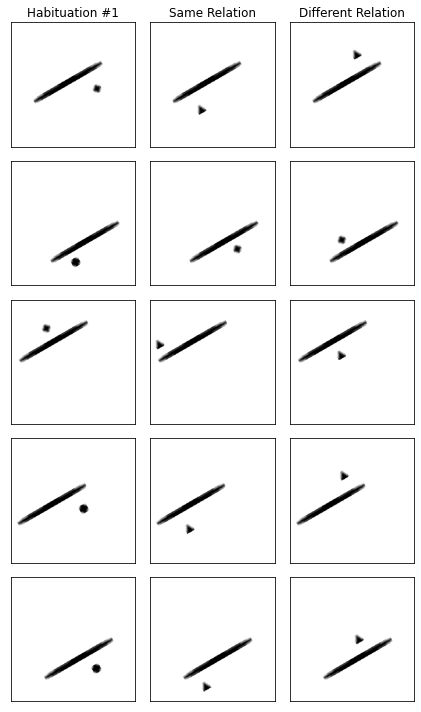

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 45 degrees

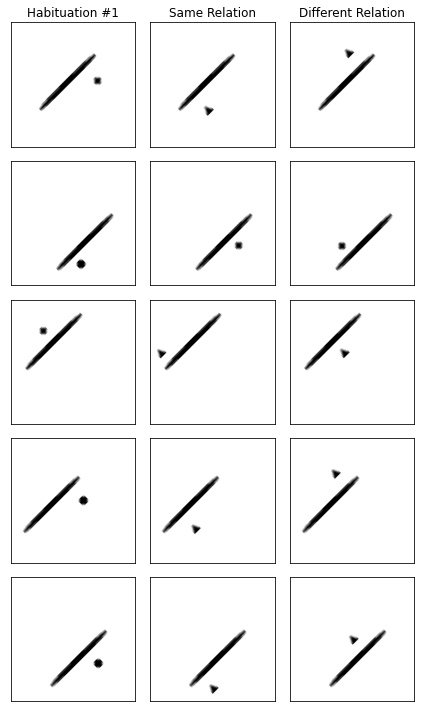

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 60 degrees

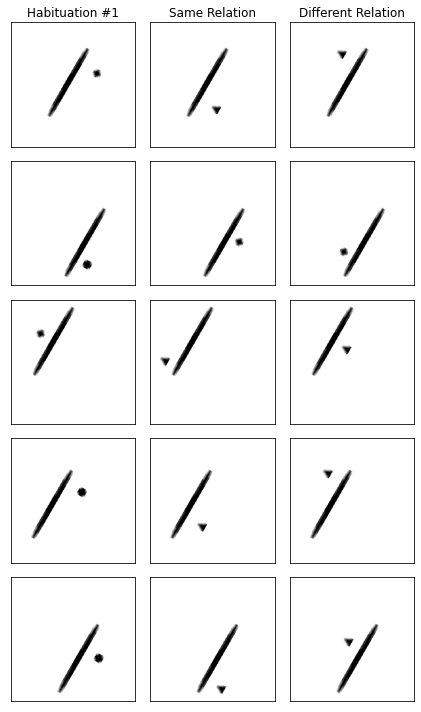

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 90 degrees

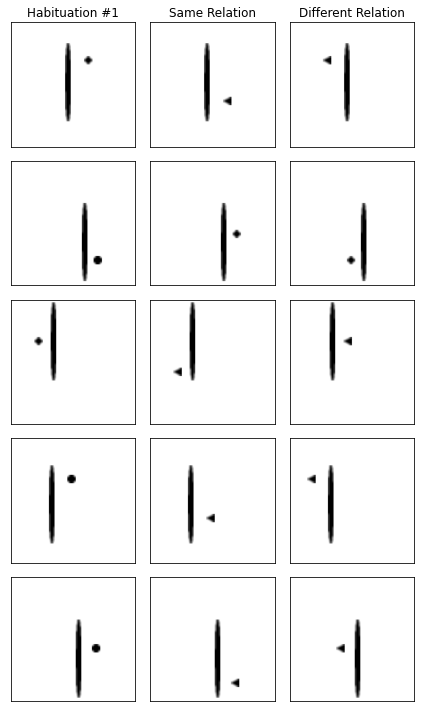

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 120 degrees

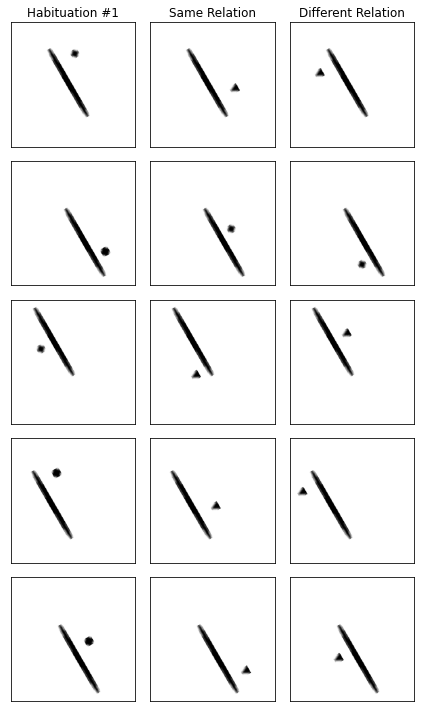

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 135 degrees

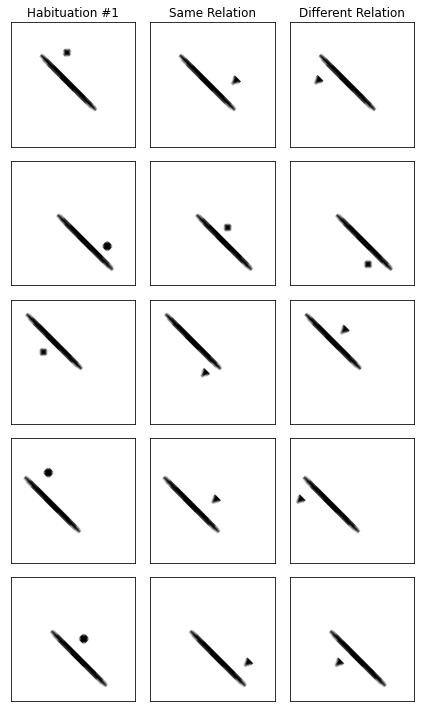

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBFBAFD9310}


## color bar | above_below | 150 degrees

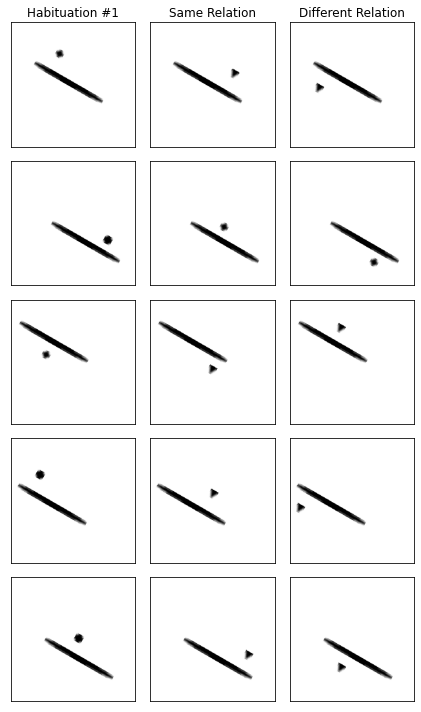

----

In [7]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = distance_endpoints_dict[(False, False)]
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for rotate_angle in (30, 45, 60, 90, 120, 135, 150):
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
        # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
        title = f'{generator_name} | {relation} | {rotate_angle} degrees'
        display(Markdown(f'## {title}'))
        triplets = triplet_generator(N_examples, normalize=False)
        plot_triplets(triplets)
        display(Markdown('----'))


# Multiple Habituation Stimuli

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174B80}


## 4 habituation stimuli

Margins: 92 0 81 0
Margins: 72 0 81 0
Margins: 83 0 81 0
Margins: 78 0 81 0
Margins: 72 0 81 0


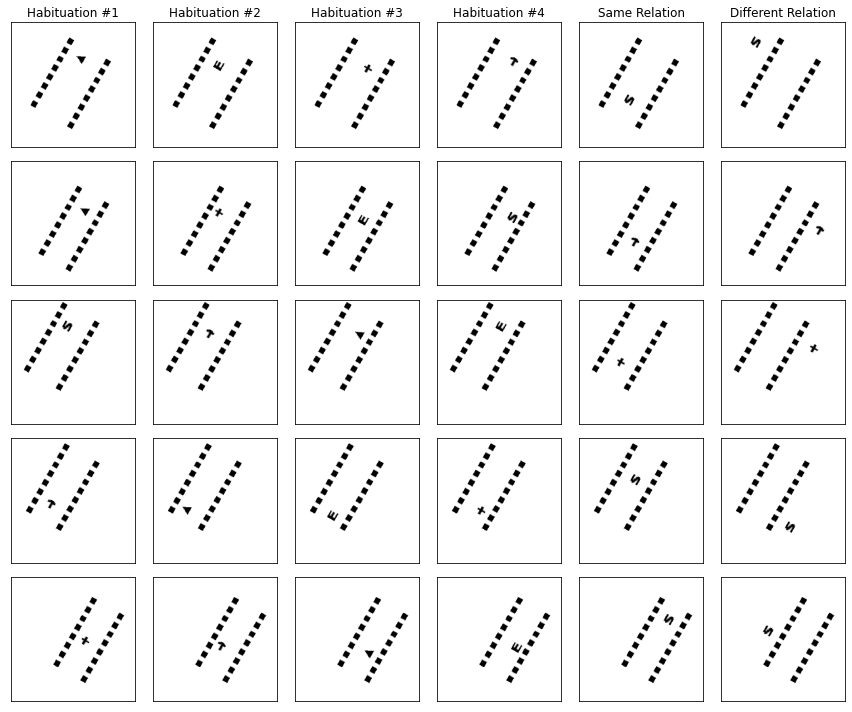

----

In [8]:
relation = BETWEEN_RELATION
distance_endpoints = (40, 80)
N_examples = 5
n_habituation_stimuli = 4

display(Markdown('# Multiple Habituation Stimuli'))

rng = np.random.default_rng(n_habituation_stimuli)
stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=60)
# stimulus_generator = build_random_color_stimulus_generator(rng=rng)

triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
    relation=relation, two_reference_objects=True, 
    adjacent_reference_objects=False, n_habituation_stimuli=n_habituation_stimuli,
    **BASELINE_TRIPLET_KWARGS)

# adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
# title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
title = f'{n_habituation_stimuli} habituation stimuli'
display(Markdown(f'## {title}'))
triplets = triplet_generator(N_examples, normalize=False)
plot_triplets(triplets)
display(Markdown('----'))


## Flipping Manipulation -- Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C788B0}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174B80}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C788B0}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174B80}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C789A0}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F87531744F0}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174A90}
Margins: 42 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174C70}
Margins: 42 0 71 0


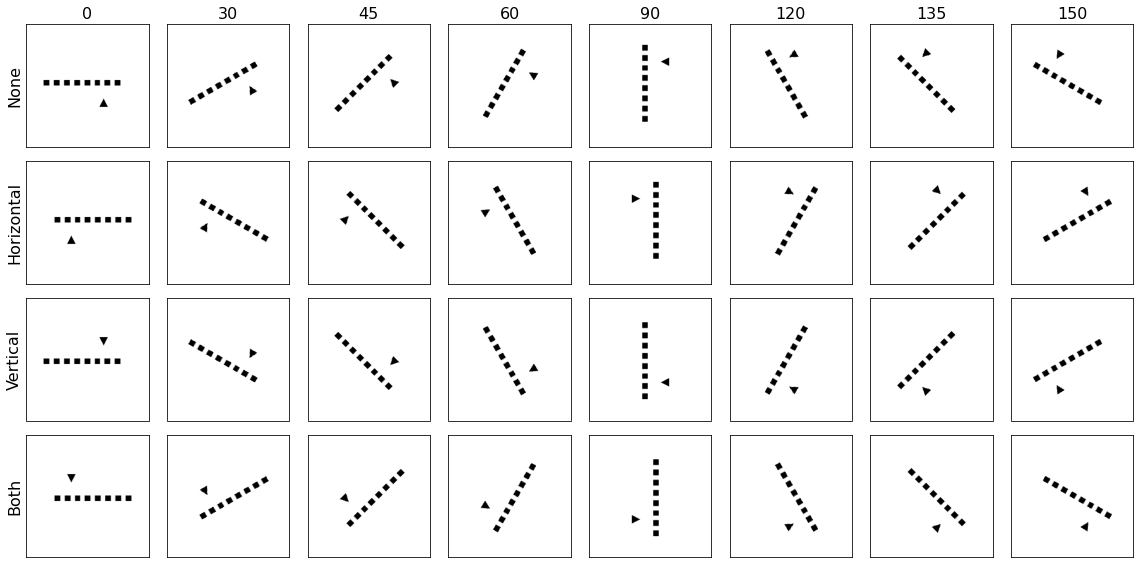

In [9]:

relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 1
seed = 33
display(Markdown('## Flipping Manipulation -- Above/Below'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)

    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=False, transpose=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][0])

plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_above_below.png',
    text_kwargs=dict(fontsize=16))

## Flipping Manipulation -- Between

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F87531749A0}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174D60}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174E50}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F87531749A0}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174D60}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F87531749A0}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C78310}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F87531749A0}
Margins: 79 0 71 0


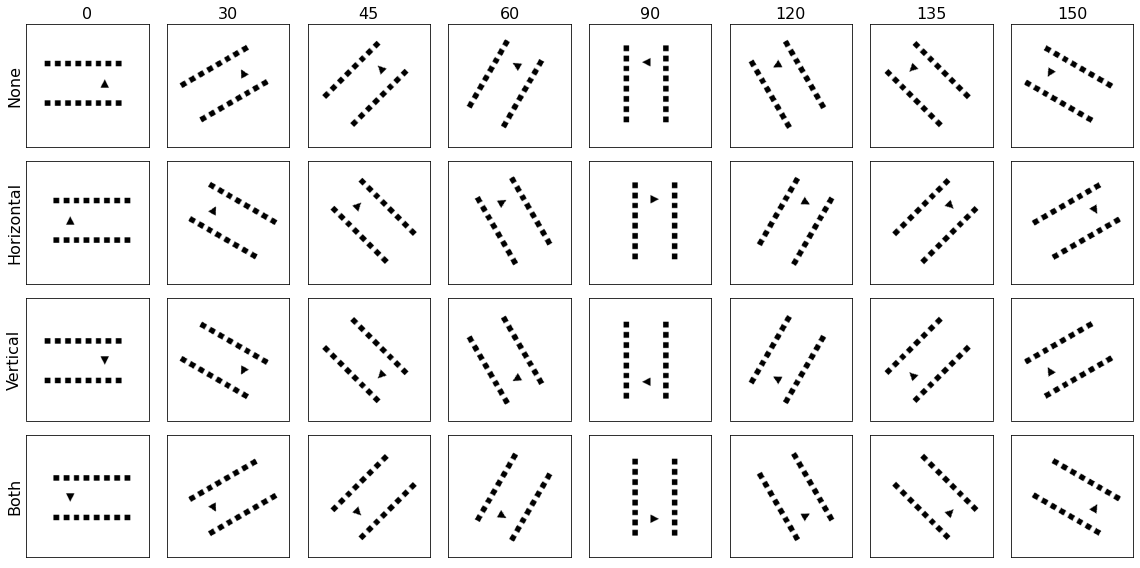

In [10]:

relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 1
TRIPLET_INDEX = 0

display(Markdown('## Flipping Manipulation -- Between'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True, transpose=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][TRIPLET_INDEX])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_between.png',
    text_kwargs=dict(fontsize=16))

## Flipping Manipulation -- Between

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C78310}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174D60}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C784F0}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C786D0}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C78A90}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C78B80}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C789A0}
Margins: 79 0 71 0
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753C78C70}
Margins: 79 0 71 0


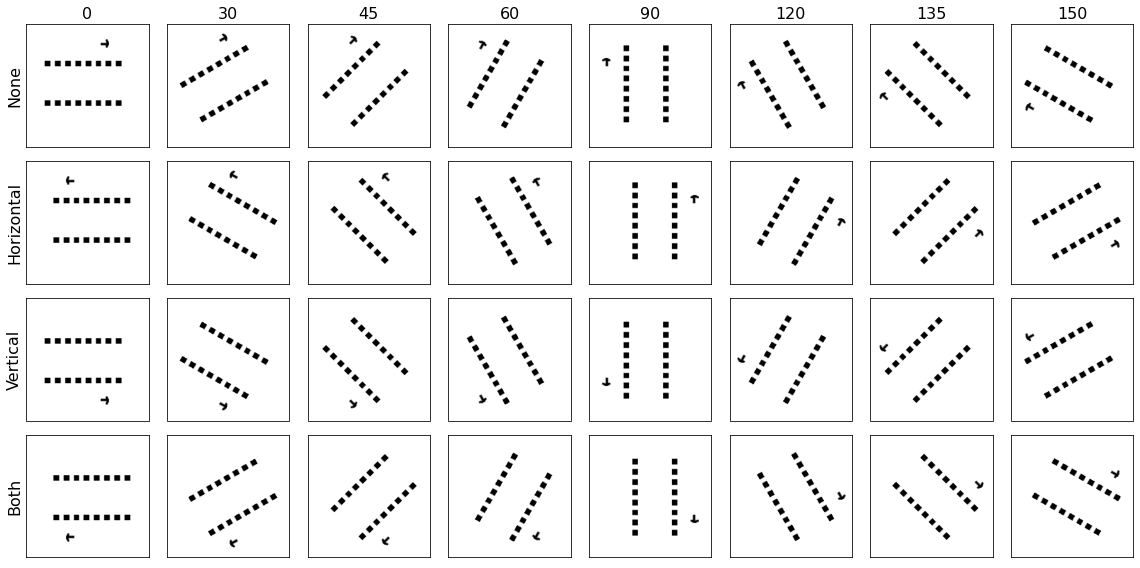

In [11]:

relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 1
TRIPLET_INDEX = 2

display(Markdown('## Flipping Manipulation -- Between'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)

    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True, transpose=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][TRIPLET_INDEX])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_outside.png',
    text_kwargs=dict(fontsize=16))

# Diagonal Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174B80}


## color bar | above_below | 45 degrees

Margins: 42 0 71 0
Margins: 29 0 71 0
Margins: 33 0 71 0
Margins: 41 0 71 0
Margins: 37 0 71 0


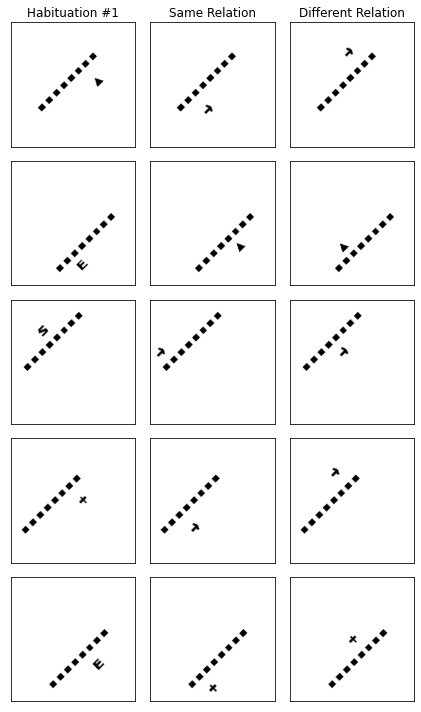

----

In [12]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

rotate_angle = 45
for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation} | {rotate_angle} degrees'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))
    break


In [13]:
N_examples = 100
ANGLES = [0, 30, 45, 60, 90, 120, 135, 150]

OPTION_SET = (
    (ABOVE_BELOW_RELATION, BETWEEN_RELATION),
    (False, True),
    (False, True),
    [1, 4],
    ANGLES
) 

total_options = np.prod([len(v) for v in OPTION_SET])
option_iter = itertools.product(*OPTION_SET)

data_rows = []

for relation, two_reference_objects, adjacent_reference_objects, n_habituation_stimuli, rotate_angle in tqdm(option_iter, total=total_options):
    if (relation == ABOVE_BELOW_RELATION) and not two_reference_objects and adjacent_reference_objects:
        continue

    if (relation == BETWEEN_RELATION) and ((not two_reference_objects) or adjacent_reference_objects):
        continue

    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=two_reference_objects,
            adjacent_reference_objects=adjacent_reference_objects, n_habituation_stimuli=n_habituation_stimuli,
            track_centroids=True,
            **BASELINE_TRIPLET_KWARGS)

        triplets = triplet_generator(N_examples, normalize=False)
        del triplets

        row = [relation, two_reference_objects, adjacent_reference_objects, n_habituation_stimuli, rotate_angle, generator_name, triplet_generator.stimulus_centroids]
        data_rows.append(row)

        del triplet_generator
        del stimulus_generator


Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8753174C70}
Margins: 42 0 71 0
Margins: 29 0 71 0
Margins: 33 0 71 0
Margins: 41 0 71 0
Margins: 37 0 71 0
Margins: 27 0 71 0
Margins: 28 0 71 0
Margins: 40 0 71 0
Margins: 33 0 71 0
Margins: 22 0 71 0
Margins: 40 0 71 0
Margins: 38 0 71 0
Margins: 40 0 71 0
Margins: 32 0 71 0
Margins: 30 0 71 0
Margins: 36 0 71 0
Margins: 26 0 71 0
Margins: 34 0 71 0
Margins: 37 0 71 0
Margins: 24 0 71 0
Margins: 42 0 71 0
Margins: 44 0 71 0
Margins: 26 0 71 0
Margins: 26 0 71 0
Margins: 42 0 71 0
Margins: 35 0 71 0
Margins: 25 0 71 0
Margins: 21 0 71 0
Margins: 37 0 71 0
Margins: 25 0 71 0
Margins: 26 0 71 0
Margins: 39 0 71 0
Margins: 35 0 71 0
Margins: 25 0 71 0
Margins: 27 0 71 0
Margins: 41 0 71 0
Margins: 37 0 71 0
Margins: 41 0 71 0
Margins: 28 0 71 0
Margins: 21 0 71 0
Margins: 31 0 71 0
Margins: 32 0 71 0
Margins: 27 0 71 0
Margins: 22 0 71 0
Margins: 38 0 71 0
Margins: 21 0 71 0
Margins: 24 0 71 0
Margins: 32 0 71 0
Margins: 28 0 71 0
Margins:

In [14]:
COLUMNS = [
    'relation', 'two_reference_objects', 
    'adjacent_reference_objects', 'n_habituation_stimuli', 
    'rotate_angle', 'stimulus_generator', 'stimulus_centroids'
]
data_df = pd.DataFrame(data_rows, columns=COLUMNS)

row_centroids, col_centroids = [], []
for centroids in data_df.stimulus_centroids:
    r, c = zip(*centroids)
    row_centroids.append(r)
    col_centroids.append(c)

data_df = data_df.assign(row_centroids=row_centroids, col_centroids=col_centroids)
# data_df.to_csv('centroid_sizes.csv', index=False)

In [15]:
data_df.head()

,relation,two_reference_objects,adjacent_reference_objects,n_habituation_stimuli,rotate_angle,stimulus_generator,stimulus_centroids,row_centroids,col_centroids
0,above_below,False,False,1,0,color bar,"[[107, 102], [147, 133], [75, 75], [118, 72], ...","(107, 147, 75, 118, 148, 91, 95, 74, 115, 130,...","(102, 133, 75, 72, 122, 91, 88, 113, 109, 95, ..."
1,above_below,False,False,1,30,color bar,"[[107, 102], [147, 133], [75, 75], [118, 72], ...","(107, 147, 75, 118, 148, 91, 95, 74, 115, 130,...","(102, 133, 75, 72, 122, 91, 88, 113, 109, 95, ..."
2,above_below,False,False,1,45,color bar,"[[107, 102], [147, 133], [75, 75], [118, 72], ...","(107, 147, 75, 118, 148, 91, 95, 74, 115, 130,...","(102, 133, 75, 72, 122, 91, 88, 113, 109, 95, ..."
3,above_below,False,False,1,60,color bar,"[[107, 102], [147, 133], [75, 75], [118, 72], ...","(107, 147, 75, 118, 148, 91, 95, 74, 115, 130,...","(102, 133, 75, 72, 122, 91, 88, 113, 109, 95, ..."
4,above_below,False,False,1,90,color bar,"[[107, 102], [147, 133], [75, 75], [118, 72], ...","(107, 147, 75, 118, 148, 91, 95, 74, 115, 130,...","(102, 133, 75, 72, 122, 91, 88, 113, 109, 95, ..."


Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8743B42130}
Margins: 42 0 71 0
Margins: 29 0 71 0
Margins: 33 0 71 0


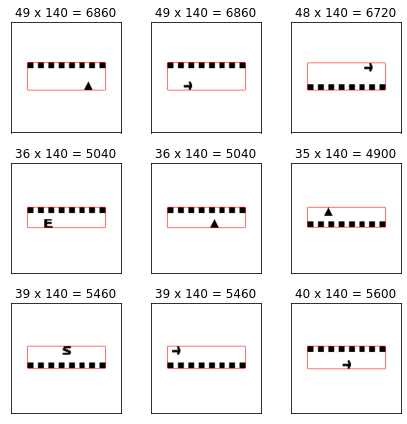

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F8743455040}
Margins: 44 0 71 0
Margins: 36 0 71 0
Margins: 38 0 71 0


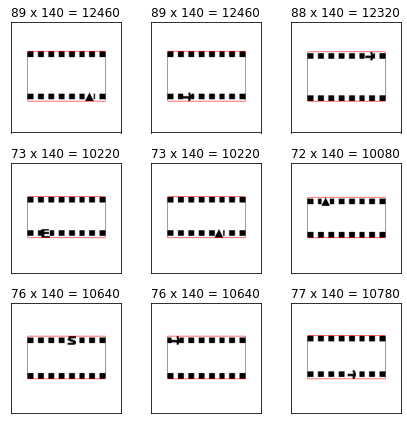

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F87203AE040}
Margins: 43 0 71 0
Margins: 33 0 71 0
Margins: 36 0 71 0


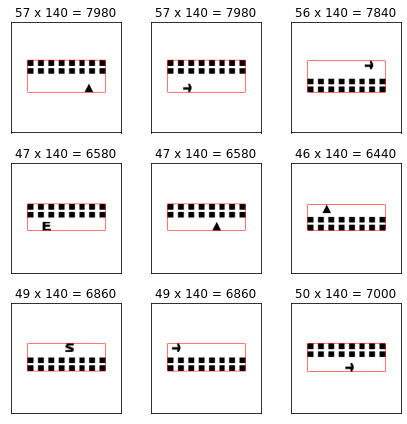

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F874264C040}
Margins: 82 0 71 0
Margins: 66 0 71 0
Margins: 71 0 71 0


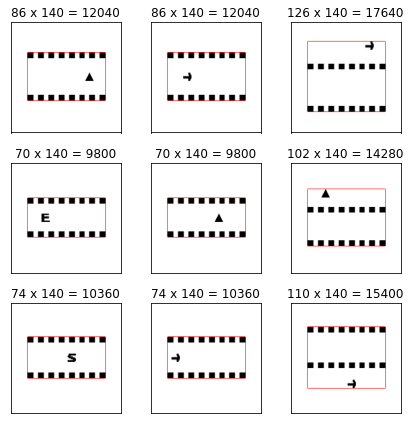

In [16]:
N_examples = 3
ANGLES = [0, 30, 45, 60, 90, 120, 135, 150]

rotate_angle = 0
n_habituation_stimuli = 1

OPTION_SET = (
    (ABOVE_BELOW_RELATION, BETWEEN_RELATION),
    (False, True),
    (False, True),
    # [1, 4],
    # ANGLES
) 

total_options = np.prod([len(v) for v in OPTION_SET])
option_iter = itertools.product(*OPTION_SET)

# for relation, two_reference_objects, adjacent_reference_objects, n_habituation_stimuli, rotate_angle in tqdm(option_iter, total=total_options):
for relation, two_reference_objects, adjacent_reference_objects in tqdm(option_iter, total=total_options):
    if (relation == ABOVE_BELOW_RELATION) and not two_reference_objects and adjacent_reference_objects:
        continue

    if (relation == BETWEEN_RELATION) and ((not two_reference_objects) or adjacent_reference_objects):
        continue

    distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=two_reference_objects,
            adjacent_reference_objects=adjacent_reference_objects,
             n_habituation_stimuli=n_habituation_stimuli,
            track_centroids=True,
            **BASELINE_TRIPLET_KWARGS)

        triplets = triplet_generator(N_examples, normalize=False)
        plot_cropped_centered_triplets(triplets)


## Comparing 90 degree rotated to transposed stimuli

# Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127F310}


## Baseline | one ref

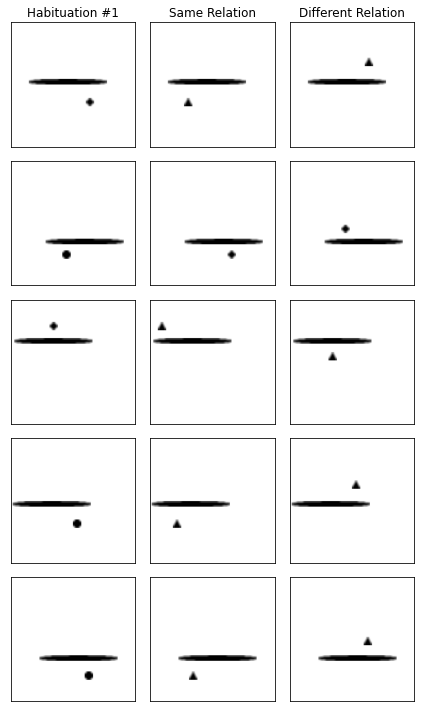

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127F8B0}


## Rotated 90 degrees | one ref

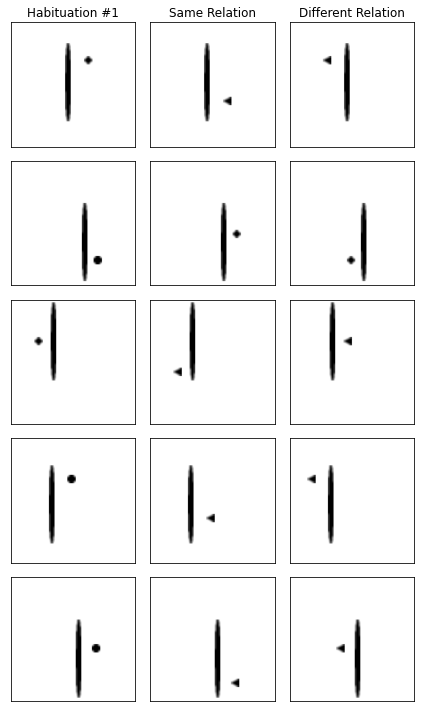

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FA90}


## Transposed | one ref

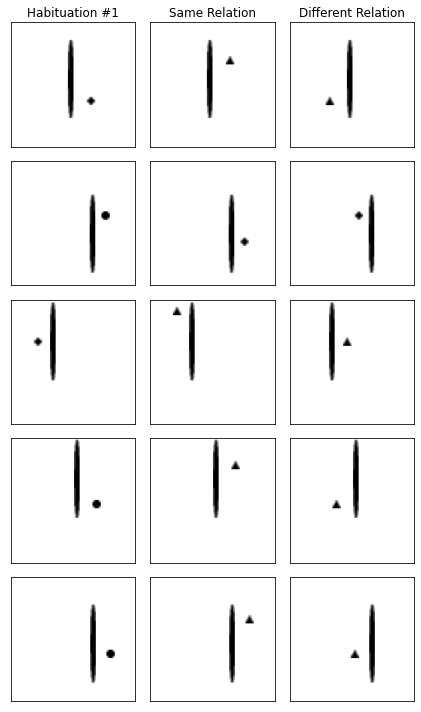

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FA90}


## Baseline | two refs | non-adjacent refs

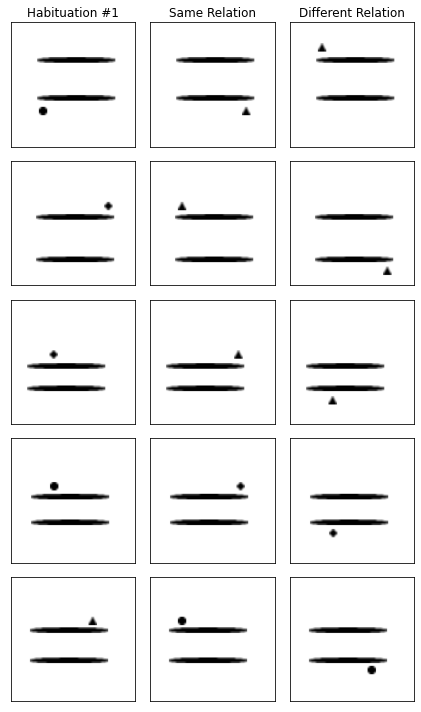

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FC70}


## Rotated 90 degrees | two refs | non-adjacent refs

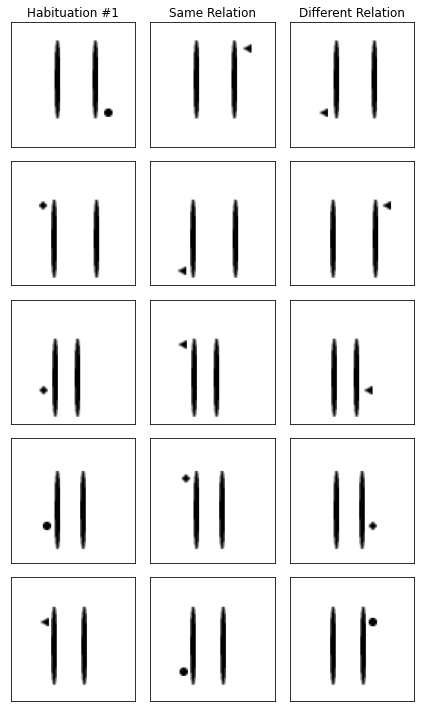

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FC70}


## Transposed | two refs | non-adjacent refs

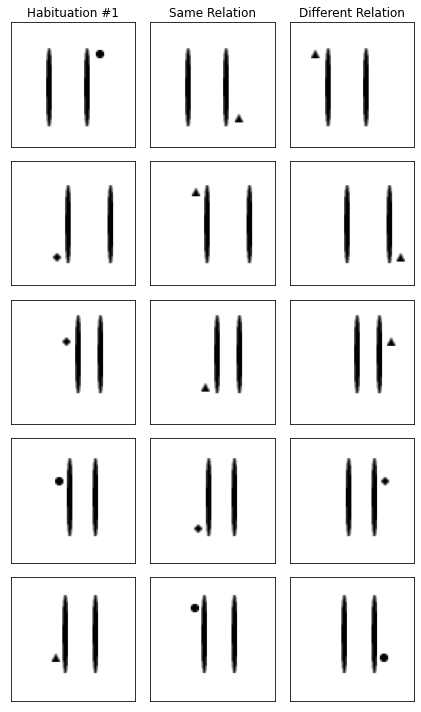

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FC70}


## Baseline | two refs | adjacent refs

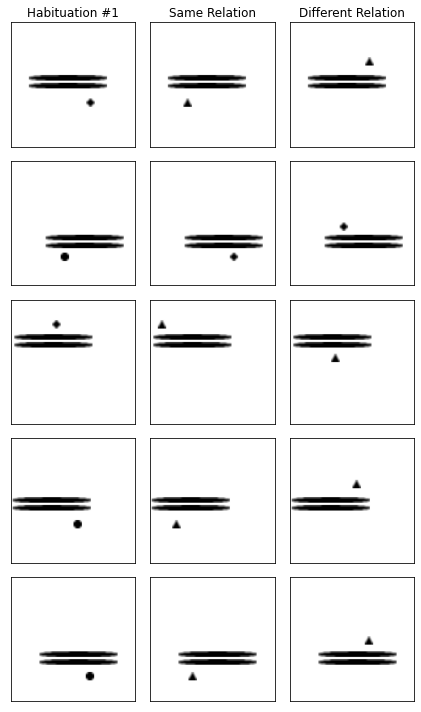

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FC70}


## Rotated 90 degrees | two refs | adjacent refs

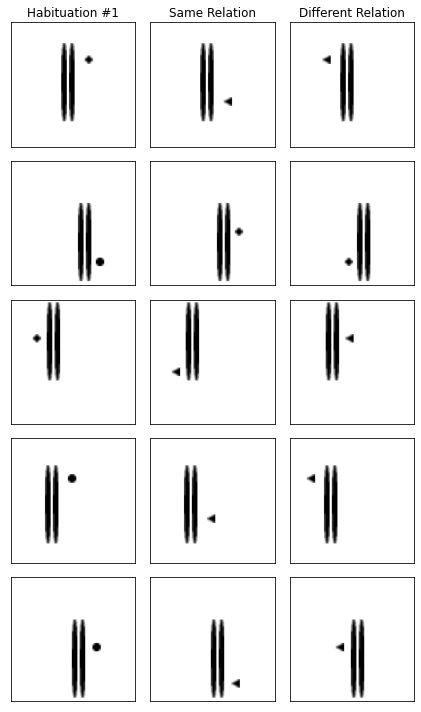

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FC70}


## Transposed | two refs | adjacent refs

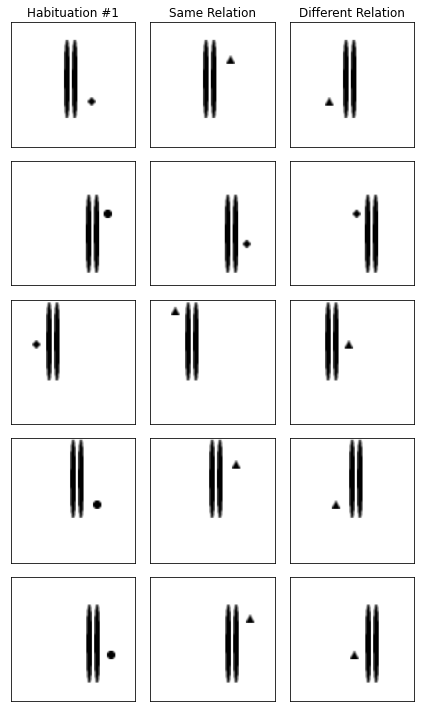

----

In [5]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for rotate_angle, transpose, name in ((0, False, 'Baseline'),  (90, False, 'Rotated 90 degrees'), (0, True, 'Transposed')):

            for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
                
                triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                    relation=relation, two_reference_objects=two_reference_objects, transpose=transpose,
                    adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

                adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
                # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                title = f'{name} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                display(Markdown(f'## {title}'))
                triplets = triplet_generator(N_examples, normalize=False)
                plot_triplets(triplets)
                display(Markdown('----'))


# Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FA90}


## Baseline | one ref

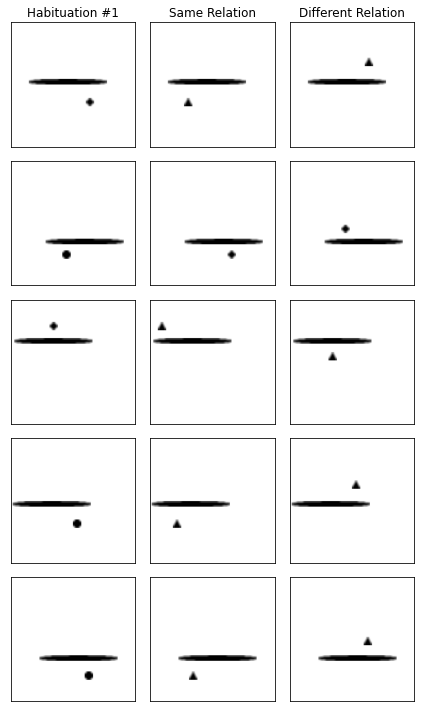

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FA90}


## Transposed and rotated | one ref

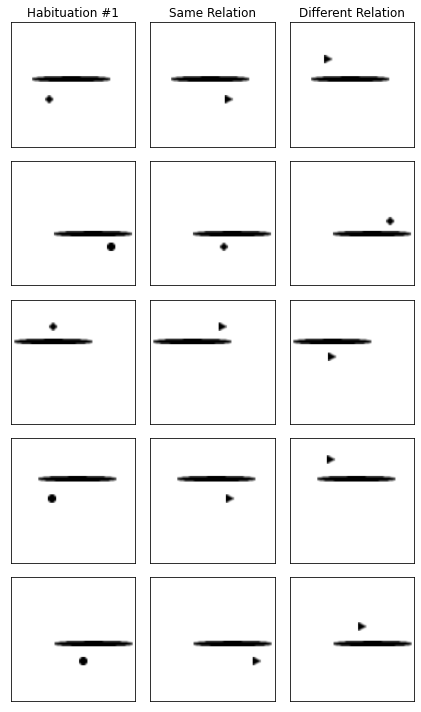

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FA90}


## Baseline | two refs | non-adjacent refs

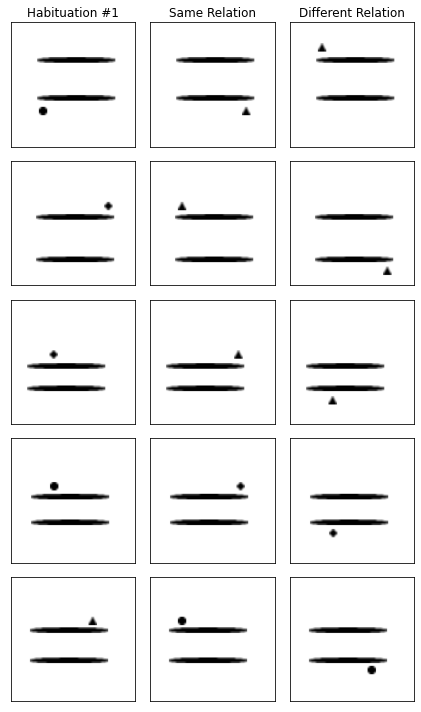

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDE127FA90}


## Transposed and rotated | two refs | non-adjacent refs

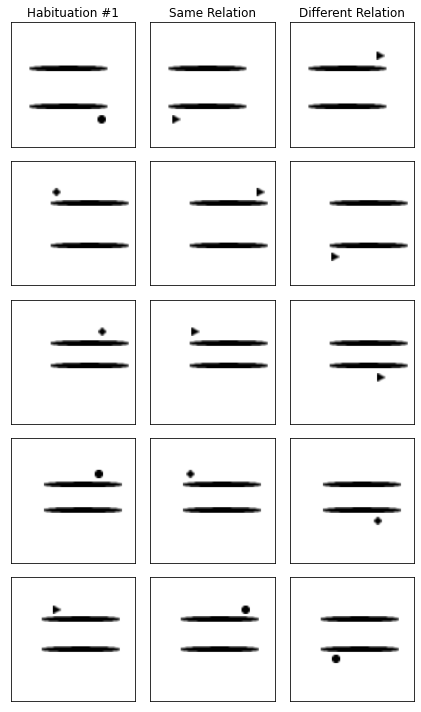

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDD952C6D0}


## Baseline | two refs | adjacent refs

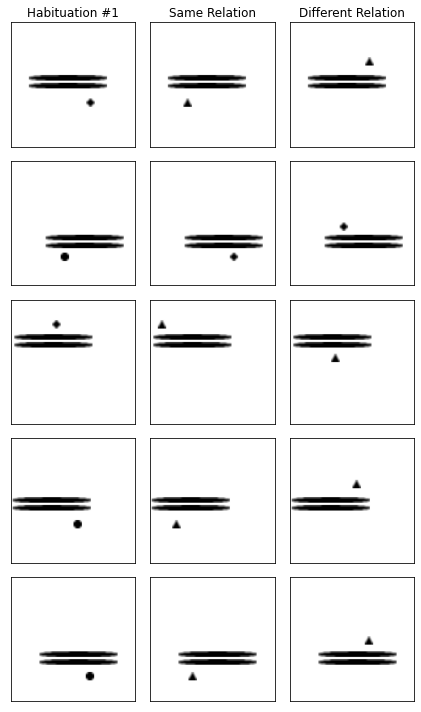

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FBDD952C6D0}


## Transposed and rotated | two refs | adjacent refs

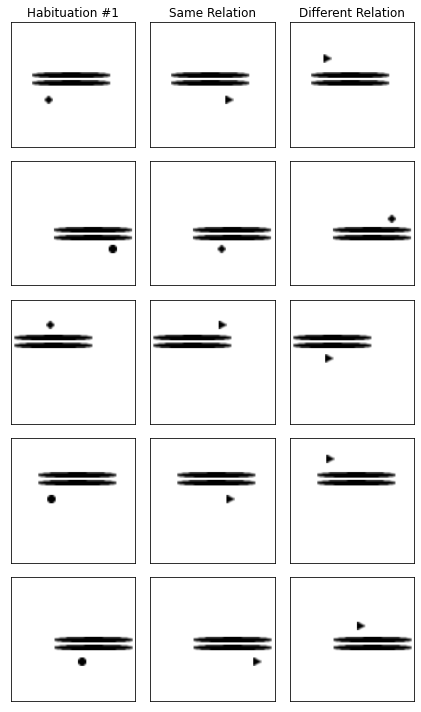

----

In [6]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for rotate_angle, transpose, name in ((0, False, 'Baseline'), (90, True, 'Transposed and rotated')):

            for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
                
                triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                    relation=relation, two_reference_objects=two_reference_objects, transpose=transpose,
                    adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

                adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
                # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                title = f'{name} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                display(Markdown(f'## {title}'))
                triplets = triplet_generator(N_examples, normalize=False)
                plot_triplets(triplets)
                display(Markdown('----'))
